# Inputs

In [1]:
# DataDir = './data/'
DataDir = './data_tmp/'
studytitle = r"$\bf{EBDC}$" + " compression\nlocalhost loopback"


# Processing

In [2]:
import os
import ntpath
import re
import pandas as pd
import numpy as np


def processDataset(dataset: str):    
    split = dataset.split('-')
    if (len(split) != 3):
        print('skip {}'.format (dataset) );
        return;
    
    zipcmd = split[0];
    ziplevel = int(split[1]);
    jobs = int(split[2]);
    datasetDir = os.path.join(DataDir, dataset)
        
    print('processing {}, {} level{} x{}'.format (datasetDir, zipcmd,ziplevel,jobs) );

    datasubfolders = [os.path.basename(f.path) for f in os.scandir(datasetDir) if f.is_file() ]
    datasubfolders.sort()
    rpv_in = re.compile('pv_in_([0-9]*)\.log')

    for data in datasubfolders:
#         print ('data = {}'.format(data));
        m = rpv_in.search(data)
        if m is not None:
#             print ('found {} -> {}'.format(data, m.group(1)));
            jobID = m.group(1);
            with open(os.path.join(datasetDir, 'pv_in_{}.log'.format(jobID))) as f:
                split = f.readlines()[-1].split();
                assert(len(split)==2)
                inTime = float(split[0])
                inSize = float(split[1])
            with open(os.path.join(datasetDir, 'pv_out_{}.log'.format(jobID))) as f:
                split = f.readlines()[-1].split();
                assert(len(split)==2)
                outTime = float(split[0])
                outSize = float(split[1])
            
#             print ('df.append {} . {} , {} -> {}'.format(data, jobID,inSize,outSize));
            dictData = { 'dataset' : dataset ,
                      'zipcmd': zipcmd,
                      'ziplevel': ziplevel,
                      'jobs': jobs,
                      'jobID': jobID,
                      'inTime': inTime,
                      'inSize': inSize,
                      'outTime': outTime  ,
                      'outSize': outSize                                        
                      } 
            global dataframe
            dataframe = dataframe.append(dictData, ignore_index=True) 



dataframe = pd.DataFrame(columns=['dataset', 'zipcmd', 'ziplevel', 'jobs', 'jobID', 'inTime', 'inSize', 'outTime', 'outSize'])
subfolders = [f.path for f in os.scandir(DataDir) if f.is_dir() ]
subfolders.sort()

for dataset in subfolders:
    processDataset(os.path.basename(dataset))



skip .ipynb_checkpoints
processing ./data_tmp/lz4-1-25, lz4 level1 x25
processing ./data_tmp/lz4-2-25, lz4 level2 x25
processing ./data_tmp/lz4-3-25, lz4 level3 x25
processing ./data_tmp/lz4-5-25, lz4 level5 x25
processing ./data_tmp/lz4-7-25, lz4 level7 x25
processing ./data_tmp/lz4-9-25, lz4 level9 x25
processing ./data_tmp/lzop-1-25, lzop level1 x25
processing ./data_tmp/lzop-2-25, lzop level2 x25
processing ./data_tmp/lzop-3-25, lzop level3 x25
processing ./data_tmp/lzop-5-25, lzop level5 x25
processing ./data_tmp/lzop-7-25, lzop level7 x25


# Plot

In [3]:
dataframeSum = pd.DataFrame(columns=['dataset', 'zipcmd', 'ziplevel', 'jobs','totalInTime', 'totalInSize', 'totalOutTime', 'totalOutSize', 'Compression', 'inRateGbps', 'outRateGbps'])

zipcmds = dataframe.zipcmd.unique()

for zipcmd in zipcmds:
    
    zipRows = dataframe.loc[dataframe['zipcmd'] == zipcmd]
    
    ziplevels = zipRows.ziplevel.unique()
    for ziplevel in ziplevels:
        ziplevelRows = zipRows.loc[zipRows['ziplevel'] == ziplevel]
        print ('processing ', zipcmd, '.',ziplevel, ' size= ',ziplevelRows.size, 'compression ratio = ',ziplevelRows['outSize'].sum()/ziplevelRows['inSize'].sum())
        assert(ziplevelRows.size>1000)
                
        dictData = { 'dataset' : ziplevelRows['dataset'].iloc[0] ,
                  'zipcmd':  ziplevelRows['zipcmd'].iloc[0] ,
                  'ziplevel':  ziplevelRows['ziplevel'].iloc[0] ,    
                  'jobs':  ziplevelRows['jobs'].iloc[0] , 
                    'totalInTime' : ziplevelRows['inTime'].sum() ,
                  'totalInSize':  ziplevelRows['inSize'].sum() ,
                  'totalOutTime':  ziplevelRows['outTime'].sum() ,    
                  'totalOutSize':  ziplevelRows['outSize'].sum() ,
                    
                  } 
        
        dictData['Compression'] = dictData['totalOutSize']/ dictData['totalInSize']
        dictData['inRateGbps'] = dictData['totalInSize']/ dictData['totalInTime'] * dictData['jobs'] *8/1e9
        dictData['outRateGbps'] = dictData['totalOutSize']/ dictData['totalOutTime']* dictData['jobs'] *8/1e9
    
        dataframeSum = dataframeSum.append(dictData, ignore_index=True) 

processing  lz4 . 1  size=  2133 compression ratio =  0.6751259046982664
processing  lz4 . 2  size=  2133 compression ratio =  0.6751259046982664
processing  lz4 . 3  size=  2133 compression ratio =  0.5778558660340661
processing  lz4 . 5  size=  2133 compression ratio =  0.5365085644373812
processing  lz4 . 7  size=  2133 compression ratio =  0.5207546008082999
processing  lz4 . 9  size=  2133 compression ratio =  0.5189943751016245
processing  lzop . 1  size=  2133 compression ratio =  0.6377294848760965
processing  lzop . 2  size=  2133 compression ratio =  0.6359905949774498
processing  lzop . 3  size=  2133 compression ratio =  0.6359905949774498
processing  lzop . 5  size=  2133 compression ratio =  0.6359905949774498
processing  lzop . 7  size=  2133 compression ratio =  0.48989600087271923


In [14]:

import matplotlib.pyplot as plt
import numpy as np

Colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']
Markers = ['o' , 's',  'D','p' , 'P']

font = {'size'   : 14}
plt.rcdefaults()
plt.rc('font', **font)

studytitle_sup = studytitle + "\n{:d} proc. 2x Xeon4216\n{:.1f}TB TPC FTBF data".format(
    dataframeSum['jobs'].iloc[0], dataframeSum['totalInSize'].iloc[0]/1e12)

## Compression plot

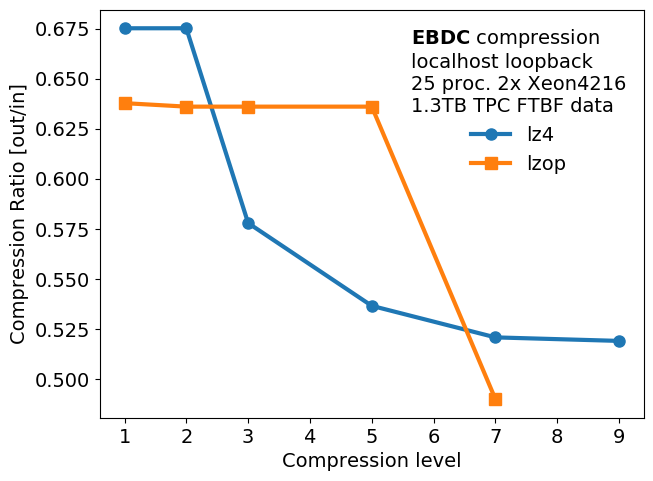

In [15]:

# dataframeSum.plot(x = 'ziplevel', y = "Compression")

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.85, 0.85])
plt.xlabel('Compression level')
plt.ylabel('Compression Ratio [out/in]')

markiter = iter(Markers);
coleriter = iter(Colors);

for zipcmd in dataframeSum.zipcmd.unique():    
    zipRows = dataframeSum.loc[dataframeSum['zipcmd'] == zipcmd]
    ax.plot(zipRows['ziplevel'].to_numpy(), zipRows['Compression'].to_numpy(),
            marker=next(markiter), color=next(coleriter), markersize = 8, linewidth = 3,
            label=zipcmd)
    
plt.legend(loc='best',title = studytitle_sup, frameon=False)

plt.savefig(os.path.join(DataDir,"Compression.png"), dpi=150)
plt.savefig(os.path.join(DataDir,"Compression.pdf"), dpi=150)


## Compressed throughput

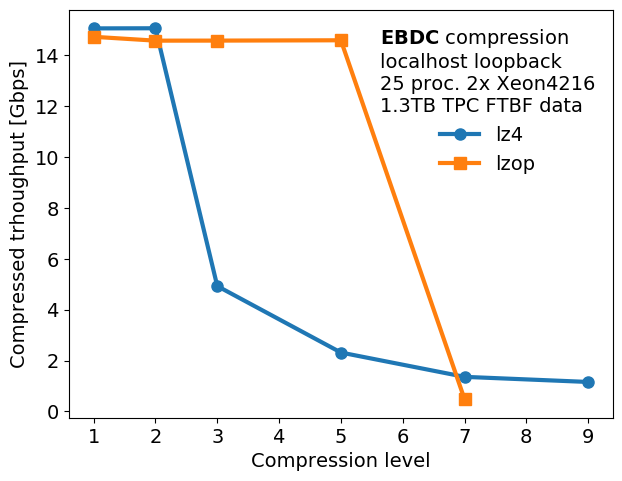

In [16]:
# dataframeSum.plot(x = 'ziplevel', y = "Compression")

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.85, 0.85])
plt.xlabel('Compression level')
plt.ylabel('Compressed trhoughput [Gbps]')

markiter = iter(Markers);
coleriter = iter(Colors);

for zipcmd in dataframeSum.zipcmd.unique():    
    zipRows = dataframeSum.loc[dataframeSum['zipcmd'] == zipcmd]
    ax.plot(zipRows['ziplevel'].to_numpy(), zipRows['outRateGbps'].to_numpy(),
            marker=next(markiter), color=next(coleriter), markersize = 8, linewidth = 3,
            label=zipcmd)
    
plt.legend(loc='best',title = studytitle_sup, frameon=False)

plt.savefig(os.path.join(DataDir,"Throughput.png"), dpi=150)
plt.savefig(os.path.join(DataDir,"Throughput.pdf"), dpi=150)

## Work point curve

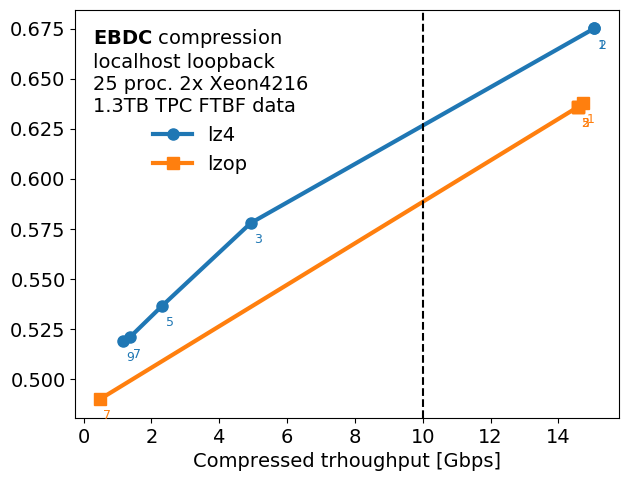

In [17]:
# dataframeSum.plot(x = 'ziplevel', y = "Compression")

fig = plt.figure()
ax = fig.add_axes([0.15, 0.15, 0.85, 0.85])
plt.xlabel('Compression ratio [in/out]')
plt.xlabel('Compressed trhoughput [Gbps]')

markiter = iter(Markers);
coleriter = iter(Colors);

for zipcmd in dataframeSum.zipcmd.unique():    
    zipRows = dataframeSum.loc[dataframeSum['zipcmd'] == zipcmd]
    outRateGbps = zipRows['outRateGbps'].to_numpy()
    Compression = zipRows['Compression'].to_numpy()
    ziplevel = zipRows['ziplevel'].to_numpy()
    c = next(coleriter)
    ax.plot(outRateGbps, Compression,
            marker=next(markiter), color=c, markersize = 8, linewidth = 3,
            label=zipcmd)
    
    for i in range(0, len(outRateGbps)):
        plt.text(outRateGbps[i]+.1, Compression[i]-.01,str(ziplevel[i]), fontsize=9, color=c)
    
#              [str(i) for i in zipRows['ziplevel'].to_numpy()], fontsize=9)
    
ax.add_line(plt.Line2D([10, 10],ax.get_ylim(), color = 'black', linestyle = '--'))

plt.legend(loc='best',title = studytitle_sup, frameon=False)

plt.savefig(os.path.join(DataDir,"FOM.png"), dpi=150)
plt.savefig(os.path.join(DataDir,"FOM.pdf"), dpi=150)

# Scratch

In [8]:
len(zipRows.index()

SyntaxError: unexpected EOF while parsing (<ipython-input-8-a8c6b77d3057>, line 1)

In [ ]:
dataframe.loc[dataframe['jobID'] == '108']